In [74]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [81]:
class Generator(nn.Module):
    def __init__(self, input_size, n_filters):
        super().__init__()

        self.network = nn.Sequential(
            nn.ConvTranspose2d(input_size, n_filters, 3, 1, 0, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_filters, n_filters // 2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(n_filters // 2),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_filters // 2, n_filters // 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters // 4),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_filters // 4, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, x):
        'Forward pass'
        output = self.network(x)
        return output

# Generate noise from normal distribution
def create_noise(batch_size, z_size):
    input_z = torch.normal(0.0, 1.0, (batch_size, z_size, 1, 1))
    return input_z


torch.manual_seed(1)

# Download and load the training set
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])
trainset = torchvision.datasets.MNIST(root="data", download=True, transform = transform)

# Create a DataLoader to efficiently load the data in Instancees
batch_size = 64
data_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

gen_input_size = 100
image_size = (28, 28)
n_filters_gen = 128
n_filters_dis = 128

generator = Generator(100, n_filters_gen)
generator.load_state_dict(torch.load("/content/gen-params-100", map_location=torch.device('cpu')))


Using 'cpu' device.


<All keys matched successfully>

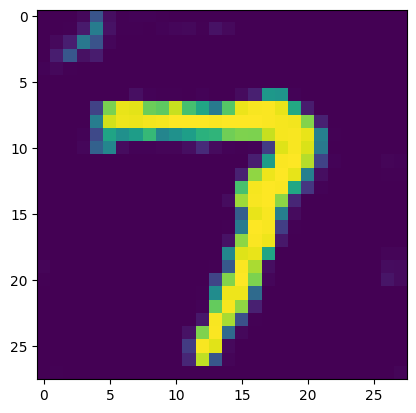

In [84]:
noise = create_noise(1, 100)
image = generator(noise).squeeze().detach().numpy()
image = (image * 0.5) + 0.5

# print(noise[0][0][0][0].item())
plt.imshow(image)

In [85]:
# Download and load the training set
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]) #changed from og code transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Create a DataLoader to efficiently load the data in Instancees
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, drop_last = True)

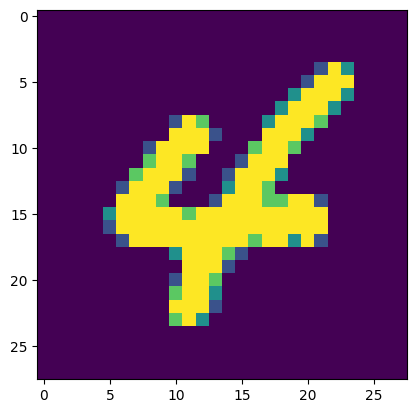

In [87]:
image_real, label = next(iter(data_loader))
image_real = image_real.squeeze().detach().numpy()
plt.imshow(image_real[0])

In [ ]:
# @title Default title text
from pytorch_fid import fid_score
from pytorch_fid.fid_score import calculate_fid_given_paths

#Makeing folders for real and fake images
current_dir = os.getcwd()
real_images_folder_name = 'real_images'
fake_images_folder_name = 'fake_images'

real_images_folder = os.path.join(current_dir, real_images_folder_name)
fake_images_folder = os.path.join(current_dir, fake_images_folder_name)

# Save real images
os.makedirs(real_images_folder, exist_ok=True)
os.makedirs(fake_images_folder, exist_ok=True)

#Saving 100 real images
num_samples1 = 99
for i in range(num_samples1):
  image_real, _ = next(iter(test_loader))  # Get a real image from DataLoader
  image_real = image_real.squeeze().detach().numpy()
  plt.imsave(os.path.join(real_images_folder, f'real_image_{i}.png'), image_real)

# Generate fake images using the generator
num_samples2 = 100
generator.eval()  # Setting generator to evaluation mode
for i in range(num_samples2): #using same num samples as above
    noise = create_noise(1, 100)
    fake_image = generator(noise).squeeze().detach().numpy()
    plt.imsave(os.path.join(fake_images_folder, f'fake_image_{i}.png'), fake_image)


In [ ]:
fid = fid_score.calculate_fid_given_paths(['/content/fake_images', '/content/real_images'], batch_size=1, device='cpu', dims=64 )

print(f"FID Score: {fid}")

In [ ]:
from skimage.metrics import structural_similarity as ssim

fake_images_folder = '/content/fake_images'
real_images_folder = '/content/real_images'

fake_image_files = [os.path.join(fake_images_folder, img) for img in os.listdir(fake_images_folder) if img.endswith('.png')]
real_image_files = [os.path.join(real_images_folder, img) for img in os.listdir(real_images_folder) if img.endswith('.png')]


# Calculate SSIM scores for all generated and real image pairs
ssim_scores = []

for fake_image_path, real_image_path in zip(fake_image_files, real_image_files):
  #Load images using matplotlib to ensure consistent image reading
  fake_image = plt.imread(fake_image_path)
  real_image = plt.imread(real_image_path)
  score = ssim(fake_image, real_image, multichannel=True)
  ssim_scores.append(score)

# Print SSIM scores
#print("SSIM Scores for Generated Images:")
#for i, score in enumerate(ssim_scores, 1):
    #print(f"Generated Image {i}: {score}")

In [ ]:
# Calculate SSIM scores for each pair of fake and real images
if ssim_scores:  # Check if ssim_scores is not empty
    # Calculate average SSIM score
    avg_ssim_score = sum(ssim_scores) / len(ssim_scores)
    print("Average SSIM Score:", avg_ssim_score)

    # Plot all SSIM scores
    plt.figure(figsize=(12, 6))
    plt.plot(ssim_scores, marker='o')
    plt.xlabel('Image Pair')
    plt.ylabel('SSIM Score')
    plt.title('SSIM Scores for Generated Images')
    plt.xticks(rotation=80, ha='right')
    plt.grid(True)
    plt.show()
else:
    print("No SSIM scores calculated. Ensure there are images in both real_images_folder and fake_images_folder.")
